In [1]:
%pip install rapidfuzz
%pip install matplotlib
%pip install wordcloud
%pip install tabulate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 26.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests #Fetches data from web APIs
import pandas as pd #Manipulates and analyses tabular data.
import matplotlib.pyplot as plt #Creates static, interactive and animated visualisation in Python
from wordcloud import WordCloud #Generates visual representations of word frequencies
from sklearn.feature_extraction.text import TfidfVectorizer #Convert to TF-IDF vector
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE #Reduces dimensionality of high-dimensional data for visu
import numpy as np #Numerical operations on arrays
from rapidfuzz import process, fuzz  # Faster alternative to fuzzywuzzy
from sklearn.preprocessing import LabelEncoder  # For encoding genre labels,
#Since genres can have multiple categories per anime (e.g.,
#"Action", "Adventure", "Fantasy"), we combined the genres and encoded them as a single string,
#then used LabelEncoder to assign numeric values to each genre combination.
import time #time-related functions
# === 1. Fetch Anime Data from MyAnimeList API ===
CLIENT_ID = "bdb4091f240563235f68cb257e9d6f80"
BASE_URL = "https://api.myanimelist.net/v2"

def fetch_anime_list(offset=0, limit=500):
    """Fetch anime rankings from MAL API."""
    url = f"{BASE_URL}/anime/ranking"
    headers = {"X-MAL-CLIENT-ID": CLIENT_ID}
    params = {
        "ranking_type": "all",
        "limit": limit,
        "offset": offset,
        "fields": "id,title,alternative_titles,genres,mean,num_list_users,id,synopsis,start_date,media_type,studios,producers,licensors"
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code != 200:
        raise Exception(f"Error: {response.status_code}, {response.json()}")

    return response.json()["data"]

# === 2. Fetch Different Ranking Ranges ===
anime_data_1 = fetch_anime_list(offset=0, limit=500)  # Top 500 (1-500)
time.sleep(1)

anime_data_2 = fetch_anime_list(offset=500, limit=500)  # Mid-tier (500-1000)
time.sleep(1)

anime_data_3 = fetch_anime_list(offset=2000, limit=500)  # Lower (2000-2500)
time.sleep(1)

anime_data_4 = fetch_anime_list(offset=4000, limit=500)  # Bottom (4000-4500)
time.sleep(1)

anime_data_5 = fetch_anime_list(offset=2000, limit=500)  # Old School (2000-2500)
time.sleep(1)

anime_data_6 = fetch_anime_list(offset=1000, limit=500)  # Mid-Low (1000-1500)
time.sleep(1)

anime_data_7 = fetch_anime_list(offset=1500, limit=500)  # Mid-Low (1000-1500)
time.sleep(2)

anime_data_8 = fetch_anime_list(offset=500, limit=500)  # Mid-tier (500-1000)
time.sleep(2)

anime_data_9 = fetch_anime_list(offset=3000, limit=500)  # Mid-tier (500-1000)
time.sleep(2)

anime_data_10 = fetch_anime_list(offset=500, limit=500)  # Mid-tier (500-1000)
time.sleep(2)

# === 3. Filter Data by Year ===
def filter_by_year(data, min_year, max_year):
    """Filter anime released within a given range."""
    return [
        anime for anime in data
        if min_year <= int(anime["node"].get("start_date", "0000-00-00").split("-")[0]) <= max_year
    ]

filtered_anime_data_2 = filter_by_year(anime_data_2, 2005, 2015)
filtered_anime_data_3 = filter_by_year(anime_data_3, 2005, 2015)
filtered_anime_data_4 = filter_by_year(anime_data_4, 2005, 2015)
filtered_anime_data_5 = filter_by_year(anime_data_5, 2000, 2004)
filtered_anime_data_6 = filter_by_year(anime_data_6, 2004, 2016)
filtered_anime_data_7 = filter_by_year(anime_data_7, 2004, 2016)
filtered_anime_data_8 = filter_by_year(anime_data_8, 2016, 2024)
filtered_anime_data_9 = filter_by_year(anime_data_9, 2004, 2015)
filtered_anime_data_10 = filter_by_year(anime_data_10, 1995, 2004)

# === 4. Combine All Data ===
combined_anime_data = (anime_data_1 + filtered_anime_data_2 + filtered_anime_data_3 +
                       filtered_anime_data_4 + filtered_anime_data_5 +
                       filtered_anime_data_8 + filtered_anime_data_10 +
                       filtered_anime_data_9 + filtered_anime_data_6 +
                       filtered_anime_data_7)

# === 5. Convert to DataFrame ===
df = pd.DataFrame([
    {
        "id": anime["node"]["id"], # This is the mal_id
        "title": anime["node"]["title"],
        "alt_titles": anime["node"].get("alternative_titles", {}).get("synonyms", []) +
                      [anime["node"].get("alternative_titles", {}).get("en", ""),
                       anime["node"].get("alternative_titles", {}).get("ja", "")],
        "genres": [g["name"] for g in anime["node"].get("genres", [])],
        "score": anime["node"].get("mean", 0),
        "popularity": anime["node"].get("num_list_users", 0),
        "synopsis": anime["node"].get("synopsis", ""),
        "release_year": int(anime["node"].get("start_date", "0000-00-00").split("-")[0])
        if anime["node"].get("start_date") else None,
        "type": anime["node"].get("media_type", None),
        "studios": [s["name"] for s in anime["node"].get("studios", [])],
        "producers": [p["name"] for p in anime["node"].get("producers", [])],
        "licensors": [l["name"] for l in anime["node"].get("licensors", [])],
        "mal_id": anime["node"]["id"] # Adding the mal_id column here
    }
    for anime in combined_anime_data
])

# === 6. Check Final Dataset ===
print(df.head())

print("Dataset Summary:\n")
print(df.info())

print("\nMissing Values (%):")
print(round(df.isnull().sum() / len(df) * 100, 2))


      id                               title  \
0  52991                   Sousou no Frieren   
1   5114    Fullmetal Alchemist: Brotherhood   
2   9253                         Steins;Gate   
3  38524  Shingeki no Kyojin Season 3 Part 2   
4  60022                One Piece Fan Letter   

                                          alt_titles  \
0  [Frieren at the Funeral, Frieren The Slayer, F...   
1  [Hagane no Renkinjutsushi: Fullmetal Alchemist...   
2                         [Steins;Gate, STEINS;GATE]   
3  [Attack on Titan Season 3 Part 2, 進撃の巨人 Season...   
4                           [, ONE PIECE FAN LETTER]   

                                              genres  score  popularity  \
0               [Adventure, Drama, Fantasy, Shounen]   9.31     1059380   
1  [Action, Adventure, Drama, Fantasy, Military, ...   9.10     3493937   
2  [Drama, Psychological, Sci-Fi, Suspense, Time ...   9.07     2675956   
3  [Action, Drama, Gore, Military, Shounen, Survi...   9.05     2417964   

In [3]:
df.head()

,id,title,alt_titles,genres,score,popularity,synopsis,release_year,type,studios,producers,licensors,mal_id
0,52991,Sousou no Frieren,"[Frieren at the Funeral, Frieren The Slayer, F...","[Adventure, Drama, Fantasy, Shounen]",9.31,1059380,During their decade-long quest to defeat the D...,2023,tv,[Madhouse],[],[],52991
1,5114,Fullmetal Alchemist: Brotherhood,[Hagane no Renkinjutsushi: Fullmetal Alchemist...,"[Action, Adventure, Drama, Fantasy, Military, ...",9.10,3493937,After a horrific alchemy experiment goes wrong...,2009,tv,[Bones],[],[],5114
2,9253,Steins;Gate,"[Steins;Gate, STEINS;GATE]","[Drama, Psychological, Sci-Fi, Suspense, Time ...",9.07,2675956,Eccentric scientist Rintarou Okabe has a never...,2011,tv,[White Fox],[],[],9253
3,38524,Shingeki no Kyojin Season 3 Part 2,"[Attack on Titan Season 3 Part 2, 進撃の巨人 Season...","[Action, Drama, Gore, Military, Shounen, Survi...",9.05,2417964,Seeking to restore humanity's diminishing hope...,2019,tv,[Wit Studio],[],[],38524
4,60022,One Piece Fan Letter,"[, ONE PIECE FAN LETTER]","[Action, Adventure, Fantasy, Shounen]",9.05,96451,Although the golden age of piracy is about to ...,2024,tv_special,[Toei Animation],[],[],60022


In [4]:
print(df['type'].mode())
print(df['genres'].mode())

0    tv
Name: type, dtype: object
0    [Action, Adventure, Fantasy, Shounen]
Name: genres, dtype: object


In [5]:
#checking if all null values are filled
df.isnull().sum()

id              0
title           0
alt_titles      0
genres          0
score           0
popularity      0
synopsis        0
release_year    0
type            0
studios         0
producers       0
licensors       0
mal_id          0
dtype: int64

In [6]:
# === 2. Preprocessing Text and Stopwords
# to Convert Synopsis into Numerical Data ===
# to make sure that we didn't end up with a bunch of
#common words again, we decided to make sure tf-idf ignores wordcloud stopwords

from wordcloud import STOPWORDS

# Custom stopwords: Adding common irrelevant words to remove them from the wordcloud
custom_stopwords = list(set(STOPWORDS).union({"i",
"Source", "one", "now", "meanwhile", "become", "seem",
"continue", "decide", "will", "take", "boy", "girl", "although", "and", "the",
"me", "him", "with", "that","new", "Written", "MAL", "however", "a", "of",
"who", "written by", "by mal", "rewrite", "ANN", "to", "ann", "aren", "didn", "doesn",
"don", "hadn", "hasn", "haven", "isn", "let", "ll", "mal", "mustn", "re", "shan", "shouldn",
"source", "ve", "wasn", "weren", "won", "wouldn", "written", "couldn"}))

# Using TfidfVectorizer to vectorize the synopsis, ignoring the stopwords
vectorizer = TfidfVectorizer(stop_words=custom_stopwords)
synopsis_matrix = vectorizer.fit_transform(df["synopsis"])

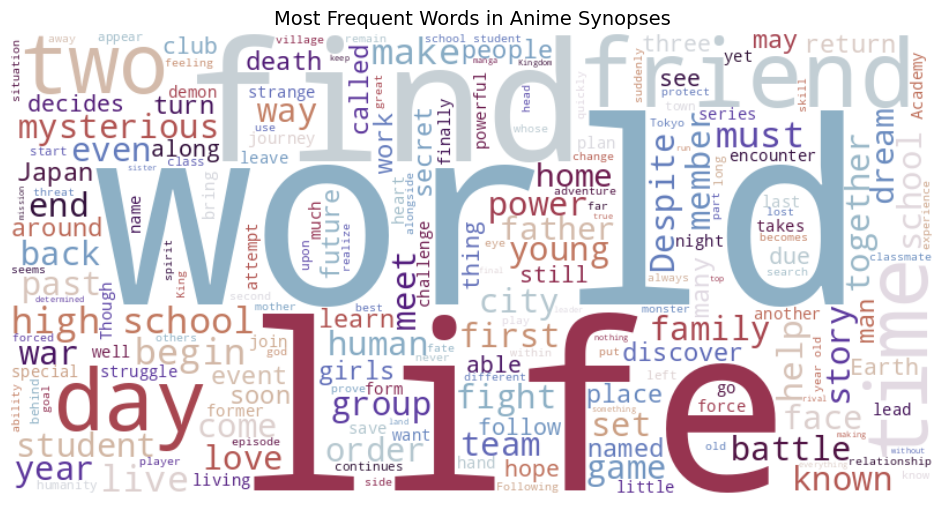

In [7]:
# === 3. Visualization ===

# 🔹 Word Cloud - Most Common Words in Anime Synopses
all_text = " ".join(df["synopsis"].dropna())

# Use custom_stopwords directly
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="twilight",
    stopwords=custom_stopwords  # Directly pass the set/list of stopwords
).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Anime Synopses", fontsize=14)
plt.show()

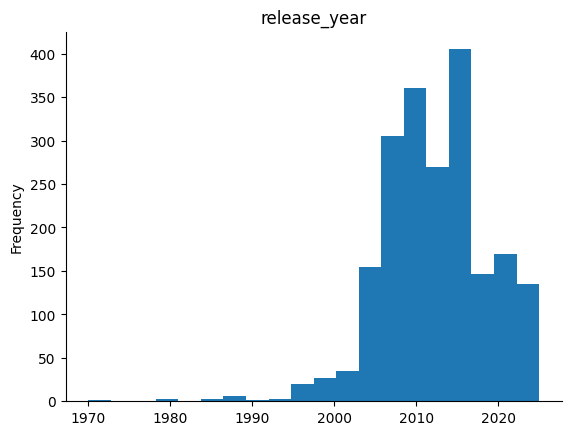

In [8]:
# @title release year

from matplotlib import pyplot as plt
df['release_year'].plot(kind='hist', bins=20, title='release_year')
plt.gca().spines[['top', 'right',]].set_visible(False)

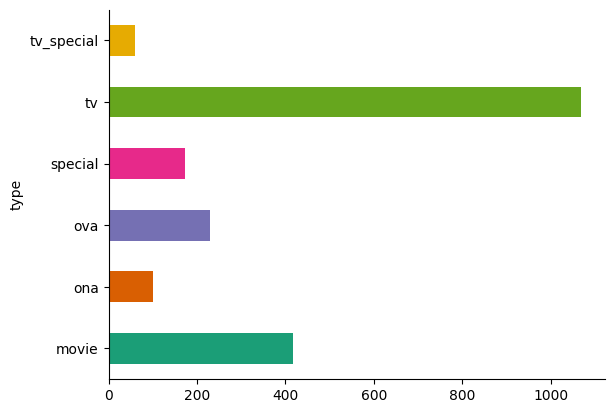

In [9]:
# @title type of media

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [10]:
# === 4. Compute Similarity ===
# Cosine similarity calculates how close two anime synopses are.
cosine_sim = cosine_similarity(synopsis_matrix, synopsis_matrix)

In [11]:
import re
from tabulate import tabulate

def recommend_anime(anime_title, top_n=20):
    """
    Recommend anime based on synopsis similarity while avoiding sequels/prequels and anime from the same universe.
    Additionally, it filters out recommendations that contain specific genres (Ecchi, Harem, Hentai, Horror)
    if the input anime doesn't contain these genres.
    """
    # Flatten title and alt_titles into one searchable list
    all_titles = df["title"].tolist() + [alt for sublist in df["alt_titles"] for alt in sublist]

    # Find best match
    match, score, _ = process.extractOne(anime_title, all_titles, scorer=fuzz.ratio)

    print(f"Match: {match}, Score: {score}")

    # Handle low similarity score
    if score < 70:
        print("Anime not found. Try checking the title.")
        return

    # Find the corresponding row in the dataframe
    match_row = df[(df["title"] == match) | (df["alt_titles"].apply(lambda x: match in x))]

    if match_row.empty:
        print("Could not find a matching anime in the dataset.")
        return

    idx = match_row.index[0]
    anime_title = df.loc[idx, "title"]
    anime_genres = df.loc[idx, "genres"]

    # Check if the input anime contains any of the filtered genres
    filtered_genres = ["Ecchi", "Harem", "Hentai", "Gore"]
    input_has_filtered_genres = any(genre in anime_genres for genre in filtered_genres)

    # Get the base title of the input anime (strip season/part info)
    input_base_title = re.sub(r'(.*?)(:|\sSeason\s|\sPart\s|\s\d)', r'\1', anime_title).strip().lower()

    # Sort Similar Anime by Cosine Similarity
    # Ensure idx is within the bounds of cosine_sim
    idx = min(idx, cosine_sim.shape[0] - 1)  # Adjust idx if it's out of bounds


    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    recommendations = []

    for i, score in sim_scores:
        candidate_title = df.iloc[i]["title"]
        candidate_genres = df.iloc[i]["genres"]

        # Skip exact match
        if candidate_title.lower() == anime_title.lower():
            continue

        # Get the base title of the candidate
        candidate_base_title = re.sub(r'(.*?)(:|\sSeason\s|\sPart\s|\s\d)', r'\1', candidate_title).strip().lower()

        # Skip sequels, prequels, movies, OVAs, and anything from the same series (based on base title match)
        if input_base_title in candidate_title.lower():
            continue  # Skip anything that contains the base title (like "One Piece" in the movie title)

        # If the input anime does not contain any filtered genres, exclude recommendations with those genres
        if not input_has_filtered_genres:
            if any(filtered_genre in candidate_genres for filtered_genre in filtered_genres):
                continue  # Skip recommendations with restricted genres

        # Add to recommendations
        recommendations.append((candidate_title, df.iloc[i]["score"], ", ".join(candidate_genres)))

        if len(recommendations) == top_n:
            break

    # Create DataFrame
    recommendations_df = pd.DataFrame(recommendations, columns=["Title", "Score", "Genres"])

    print("\nRecommended Anime:")
    print(tabulate(recommendations_df, headers="keys", tablefmt="pretty"))

In [12]:
# === Example General Recommendation===
user_anime = "One Piece"
print(f"\n=== Recommendations for {user_anime} ===")
recommend_anime(user_anime)


=== Recommendations for One Piece ===
Match: One Piece, Score: 100.0

Recommended Anime:
+----+-----------------------------------------------------+-------+-------------------------------------------------------------------------+
|    |                        Title                        | Score |                                 Genres                                  |
+----+-----------------------------------------------------+-------+-------------------------------------------------------------------------+
| 0  |              Seihou Bukyou Outlaw Star              | 7.83  |            Action, Adventure, Comedy, Sci-Fi, Seinen, Space             |
| 1  |                 Dr. Stone: Ryuusui                  | 8.14  |                   Adventure, Comedy, Sci-Fi, Shounen                    |
| 2  |               Niehime to Kemono no Ou               | 7.94  |                Anthropomorphic, Fantasy, Romance, Shoujo                |
| 3  |                 K: Return of Kings           

In [13]:
import re
from tabulate import tabulate

def recommend_tv_anime(anime_title, top_n=20):
    """
    Recommend TV-type anime based on synopsis similarity while avoiding sequels/prequels and anime from the same universe.
    """
    # Flatten title and alt_titles into one searchable list
    all_titles = df["title"].tolist() + [alt for sublist in df["alt_titles"] for alt in sublist]

    # Find best match
    match, score, _ = process.extractOne(anime_title, all_titles, scorer=fuzz.ratio)

    print(f"Match: {match}, Score: {score}")

    # Handle low similarity score
    if score < 70:
        print("Anime not found. Try checking the title.")
        return

    # Find the corresponding row in the dataframe
    match_row = df[(df["title"] == match) | (df["alt_titles"].apply(lambda x: match in x))]

    if match_row.empty:
        print("Could not find a matching anime in the dataset.")
        return

    idx = match_row.index[0]
    anime_title = df.loc[idx, "title"]

    # Get the base title of the input anime (strip season/part info)
    input_base_title = re.sub(r'(.*?)(:|\sSeason\s|\sPart\s|\s\d)', r'\1', anime_title).strip().lower()

    # Sort Similar Anime by Cosine Similarity
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    recommendations = []

    for i, score in sim_scores:
        candidate_title = df.iloc[i]["title"]
        candidate_genres = ", ".join(df.iloc[i]["genres"])
        candidate_type = df.iloc[i]["type"].lower()  # Check type (TV, Movie, etc.)

        # Skip non-TV types
        if candidate_type != "tv":
            continue

        # Skip exact match
        if candidate_title.lower() == anime_title.lower():
            continue

        # Get the base title of the candidate
        candidate_base_title = re.sub(r'(.*?)(:|\sSeason\s|\sPart\s|\s\d)', r'\1', candidate_title).strip().lower()

        # Skip sequels, prequels, movies, OVAs, and anything from the same series (based on base title match)
        if input_base_title in candidate_title.lower():
            continue  # Skip anything that contains the base title (like "One Piece" in the movie title)

        # Add to recommendations
        recommendations.append((candidate_title, df.iloc[i]["score"], candidate_genres))

        if len(recommendations) == top_n:
            break

    # Create DataFrame
    recommendations_df = pd.DataFrame(recommendations, columns=["Title", "Score", "Genres"])

    print("\nRecommended TV Anime:")
    print(tabulate(recommendations_df, headers="keys", tablefmt="pretty"))

In [14]:
# Example TV shows Only Recommendation
user_anime = "Shugo Chara"
print(f"\n=== TV Recommendations for {user_anime} ===")
recommend_tv_anime(user_anime)


=== TV Recommendations for Shugo Chara ===
Match: Shugo Chara!, Score: 95.65217391304348

Recommended TV Anime:
+----+------------------------------------------------------------+-------+------------------------------------------------------------------------------------+
|    |                           Title                            | Score |                                       Genres                                       |
+----+------------------------------------------------------------+-------+------------------------------------------------------------------------------------+
| 0  |       Bishoujo Senshi Sailor Moon Crystal Season III       | 7.77  |                           Mahou Shoujo, Romance, Shoujo                            |
| 1  |                    Seitokai Yakuindomo                     | 7.54  |                         Comedy, Gag Humor, School, Shounen                         |
| 2  |                Fumetsu no Anata e Season 2                 | 8.09  |       

In [15]:
import re
from tabulate import tabulate

def recommend_movie_anime(anime_title, top_n=20):
    """
    Recommend movie-type anim ue based on synopsis similarity while avoiding sequels/prequels and anime from the same universe.
    """
    # Flatten title and alt_titles into one searchable list
    all_titles = df["title"].tolist() + [alt for sublist in df["alt_titles"] for alt in sublist]

    # Find best match
    match, score, _ = process.extractOne(anime_title, all_titles, scorer=fuzz.ratio)

    print(f"Match: {match}, Score: {score}")

    # Handle low similarity score
    if score < 70:
        print("Anime not found. Try checking the title.")
        return

    # Find the corresponding row in the dataframe
    match_row = df[(df["title"] == match) | (df["alt_titles"].apply(lambda x: match in x))]

    if match_row.empty:
        print("Could not find a matching anime in the dataset.")
        return

    idx = match_row.index[0]
    anime_title = df.loc[idx, "title"]

    # Get the base title of the input anime (strip season/part info)
    input_base_title = re.sub(r'(.*?)(:|\sSeason\s|\sPart\s|\s\d)', r'\1', anime_title).strip().lower()

    # Sort Similar Anime by Cosine Similarity
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    recommendations = []

    for i, score in sim_scores:
        candidate_title = df.iloc[i]["title"]
        candidate_genres = ", ".join(df.iloc[i]["genres"])
        candidate_type = df.iloc[i]["type"].lower()  # Check type (TV, Movie, etc.)

        # Skip non-Movie types
        if candidate_type != "movie":
            continue

        # Skip exact match
        if candidate_title.lower() == anime_title.lower():
            continue

        # Get the base title of the candidate
        candidate_base_title = re.sub(r'(.*?)(:|\sSeason\s|\sPart\s|\s\d)', r'\1', candidate_title).strip().lower()

        # Skip sequels, prequels, and anything from the same series (based on base title match)
        if input_base_title in candidate_title.lower():
            continue  # Skip anything that contains the base title (like "One Piece" in the movie title)

        # Add to recommendations
        recommendations.append((candidate_title, df.iloc[i]["score"], candidate_genres))

        if len(recommendations) == top_n:
            break

    # Create DataFrame
    recommendations_df = pd.DataFrame(recommendations, columns=["Title", "Score", "Genres"])

    print("\nRecommended Movie Anime:")
    print(tabulate(recommendations_df, headers="keys", tablefmt="pretty"))

In [16]:
# Example Movies Only Recommendation
user_anime = "Summer Wars"
print(f"\n=== Recommendations for {user_anime} ===")
recommend_movie_anime(user_anime)


=== Recommendations for Summer Wars ===
Match: Summer Wars, Score: 100.0

Recommended Movie Anime:
+----+----------------------------------------------------------------+-------+-------------------------------------------------------------------------------------------------------+
|    |                             Title                              | Score |                                                Genres                                                 |
+----+----------------------------------------------------------------+-------+-------------------------------------------------------------------------------------------------------+
| 0  |                      Koukaku Kidoutai 2.0                      | 7.96  |        Action, Adult Cast, Detective, Mecha, Mystery, Psychological, Sci-Fi, Seinen, Suspense         |
| 1  | Koukaku Kidoutai: Stand Alone Complex - Solid State Society 3D | 7.72  |                Action, Adult Cast, Detective, Mecha, Military, Mystery, Sci-Fi, Sein